# Testing the ingestion of calibration-day data

My initial implementation of run_create_ingested et al had the problem that calibration days failed. This is partially due to one of the calibration files having $1000<1200$ height bins, so inserting it into the xarray Dataset failed.

However, simply omitting the files seems to have problems with the Pandas indexing when ingesteing the data.

My aim is to fix this problem...

In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
import datetime

In [2]:
# importing local files for use...
from src import load_mpl_inline
from src import load_afterpulse

from src import raw_to_ingested
from src import calibrate_ingested

In [3]:
# setup path to load files from
dir_data = '/gws/nopw/j04/ncas_radar_vol2/data/ICECAPSarchive/mpl/raw'
dir_output = '/gws/nopw/j04/ncas_radar_vol2/data/ICECAPSarchive/mpl/leeds_ingested'

## Test date: `2019-02-03`

I will effectively go through the steps of `create_ingested.create_ingested` to see at which point the ingestion fails.

In [4]:
# get the list of files...
date = datetime.date(2019,2,3)
save_fname = f'smtmplpolX1.a1.{date.year:04}{date.month:02}{date.day:02}.000000.cdf'

fname_glob = f'{date.year:04}{date.month:02}{date.day:02}*.mpl.gz'
print(fname_glob)
ds = load_mpl_inline.mf_load_mpl_inline(fname_glob, dir_data)
ds

20190203*.mpl.gz
Loading: |0000|0100|0200|0300|0400|0500|0600|0700|0800|0900|1000|1100|1200|1300|1400|1500|1600|1700|1800|1900|2000|2100|2200|2300|


<xarray.Dataset>
Dimensions:                      (profile: 17281, range: 1999)
Dimensions without coordinates: profile, range
Data variables: (12/52)
    unit                         (profile) float32 108.0 108.0 ... 108.0 108.0
    version                      (profile) float32 413.0 413.0 ... 413.0 413.0
    shots_sum                    (profile) float64 1.25e+04 ... 1.25e+04
    trigger_frequency            (profile) float64 2.5e+03 2.5e+03 ... 2.5e+03
    energy_monitor               (profile) float64 5.298e+03 ... 5.243e+03
    temp_0                       (profile) float64 1.455e+03 ... 1.332e+03
    ...                           ...
    channel_2                    (profile, range) float32 0.0 0.0016 ... 0.0 0.0
    time_utc                     (profile) object '2019-02-03T00:00:04' ... '...
    time                         (profile) datetime64[ns] 2019-02-03T00:00:04...
    c                            (profile) float64 2.998e+08 ... 2.998e+08
    nrb_copol                    (profile, range) float64 -3.571e-09 ... -0.0...
    nrb_crosspol                 (profile, range) float64 -3.125e-09 ... -0.0...
Attributes:
    created:   2023-03-14T:18:18:25Z
    software:  mpl2nc (https://github.com/peterkuma/mpl2nc)
    version:   1.3.5

In [5]:
# need to check that all time measurements are unique. Otherwise, will need to subset all subsequent data...
times = ds.time.values
uniq_times, uniq_ind, uniq_n = np.unique(times,return_index=True, return_counts=True)
print(uniq_times.shape)
print(uniq_ind.shape)
print(uniq_n.shape)

if uniq_times.size != times.size: # if there are duplicate times
    data_loaded = ds.isel(profile=uniq_ind)
data_loaded

(17280,)
(17280,)
(17280,)


<xarray.Dataset>
Dimensions:                      (profile: 17280, range: 1999)
Dimensions without coordinates: profile, range
Data variables: (12/52)
    unit                         (profile) float32 108.0 108.0 ... 108.0 108.0
    version                      (profile) float32 413.0 413.0 ... 413.0 413.0
    shots_sum                    (profile) float64 1.25e+04 ... 1.25e+04
    trigger_frequency            (profile) float64 2.5e+03 2.5e+03 ... 2.5e+03
    energy_monitor               (profile) float64 5.298e+03 ... 5.243e+03
    temp_0                       (profile) float64 1.455e+03 ... 1.332e+03
    ...                           ...
    channel_2                    (profile, range) float32 0.0 0.0016 ... 0.0 0.0
    time_utc                     (profile) object '2019-02-03T00:00:04' ... '...
    time                         (profile) datetime64[ns] 2019-02-03T00:00:04...
    c                            (profile) float64 2.998e+08 ... 2.998e+08
    nrb_copol                    (profile, range) float64 -3.571e-09 ... -0.0...
    nrb_crosspol                 (profile, range) float64 -3.125e-09 ... -0.0...
Attributes:
    created:   2023-03-14T:18:18:25Z
    software:  mpl2nc (https://github.com/peterkuma/mpl2nc)
    version:   1.3.5

Using `load_mpl_inline.mf_load_mpl_inline` has resulted in the `ds.combine_nested` function failing, as one of the calibration files has a different number f range bins.

```python
ValueError: cannot reindex or align along dimension 'range' because of conflicting dimension sizes: {999, 1999}
```

What if we say sod it and skip the files that don't begin on the hour...

In [ ]:
fname_glob = f'{date.year:04}{date.month:02}{date.day:02}*00.mpl.gz' # note the additional 00
print(fname_glob)
ds = load_mpl_inline.mf_load_mpl_inline(fname_glob, dir_data)
ds

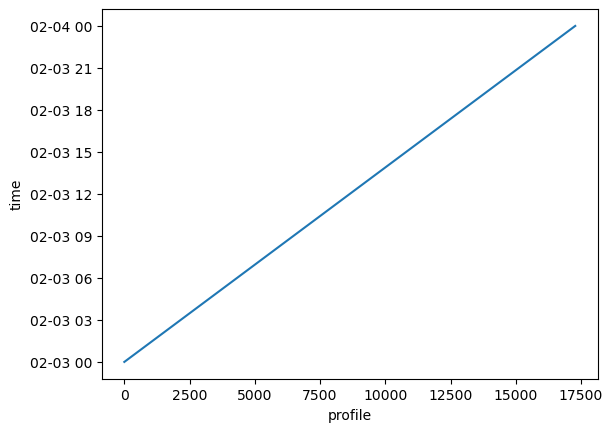

In [6]:
ds.time.plot()

In [7]:
# apply the raw_to_ingested algorithm on the already-loaded ds
ds = raw_to_ingested.raw_to_ingested(None, None, data_loaded=ds)

<xarray.Dataset>
Dimensions:  (time: 17280, height: 1200)
Coordinates:
  * time     (time) datetime64[ns] 2019-02-03T00:00:04 ... 2019-02-03T23:59:58
  * height   (height) float64 -3e+03 -2.985e+03 ... 1.496e+04 1.497e+04
Data variables:
    *empty*


In [8]:
ds

<xarray.Dataset>
Dimensions:          (time: 17280, height: 1200)
Coordinates:
  * time             (time) datetime64[ns] 2019-02-03T00:00:04 ... 2019-02-03...
  * height           (height) float64 -3e+03 -2.985e+03 ... 1.496e+04 1.497e+04
Data variables: (12/19)
    base_time        datetime64[ns] 2019-02-03T00:00:04
    time_offset      (time) timedelta64[ns] 00:00:00 00:00:05 ... 23:59:54
    hour             (time) float32 0.001111 0.0025 0.003889 ... 24.0 24.0 24.0
    nshots           (time) int32 12500 12500 12500 12500 ... 12500 12500 12500
    rep_rate         (time) int32 2500 2500 2500 2500 ... 2500 2500 2500 2500
    energy           (time) float32 5.298 5.298 5.297 ... 5.244 5.245 5.243
    ...               ...
    initial_cbh      (time) float32 0.0 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0 0.0
    backscatter_1    (time, height) float32 0.0 0.0 0.0016 ... 0.0 0.0016 0.0
    backscatter_2    (time, height) float32 0.0 0.0016 0.0016 ... 0.0016 0.0 0.0
    lat              float32 72.6
    lon              float32 -38.42
    alt              float32 3.2e+03
Attributes:
    Date_created:              2023-03-14T18:19:05 UTC
    Ingest_version:            Id: mpl/raw_to_ingested.py ,v 0.1 2023/02/14 
    comment:                   DOE Atmospheric Radiation Measurement (ARM) Mi...
    Author:                    Dave Turner, NOAA National Severe Storms Labor...
    instrument_serial_number:  108
    instrument_version:        413
    backscatter_comment:       See Flynn et al. 2007 Optics Express paper for...

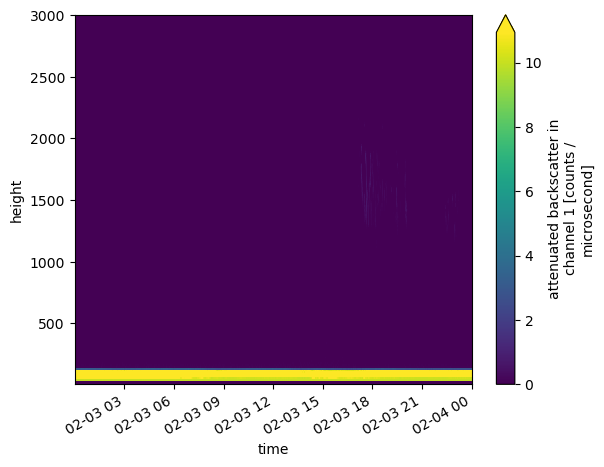

In [9]:
ds.backscatter_1.sel(height=slice(0,3000)).plot(x='time',y='height',robust=True)

In [10]:
# add calibrated variables to the ingested format
ds = calibrate_ingested.calibrate_ingested(ds, afterpulse=None, overlap=None, sources=None)
ds

<xarray.Dataset>
Dimensions:          (time: 17280, height: 1200)
Coordinates:
  * time             (time) datetime64[ns] 2019-02-03T00:00:04 ... 2019-02-03...
  * height           (height) float64 -3e+03 -2.985e+03 ... 1.496e+04 1.497e+04
Data variables: (12/27)
    base_time        datetime64[ns] 2019-02-03T00:00:04
    time_offset      (time) timedelta64[ns] 00:00:00 00:00:05 ... 23:59:54
    hour             (time) float32 0.001111 0.0025 0.003889 ... 24.0 24.0 24.0
    nshots           (time) int32 12500 12500 12500 12500 ... 12500 12500 12500
    rep_rate         (time) int32 2500 2500 2500 2500 ... 2500 2500 2500 2500
    energy           (time) float32 5.298 5.298 5.297 ... 5.244 5.245 5.243
    ...               ...
    dz               float64 14.99
    E_photon         float64 3.734e-19
    NRB_2            (time, height) float64 nan nan nan nan ... nan nan nan nan
    depol_mpl        (time, height) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    depol_linear     (time, height) float64 0.0 0.0 0.0 0.0 ... 0.0 0.0 0.0 0.0
    NRB_total        (time, height) float64 nan nan nan nan ... nan nan nan nan
Attributes:
    Date_created:              2023-03-14T18:19:05 UTC
    Ingest_version:            Id: mpl/raw_to_ingested.py ,v 0.1 2023/02/14 
    comment:                   DOE Atmospheric Radiation Measurement (ARM) Mi...
    Author:                    Dave Turner, NOAA National Severe Storms Labor...
    instrument_serial_number:  108
    instrument_version:        413
    backscatter_comment:       See Flynn et al. 2007 Optics Express paper for...

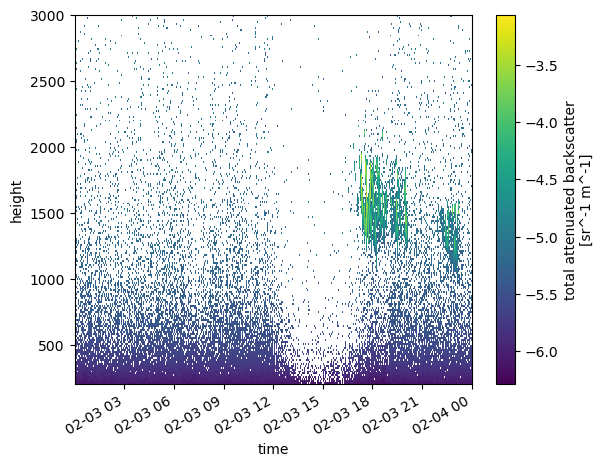

In [14]:
np.log10(ds.NRB_total.sel(height=slice(200,3000))).plot(x='time',y='height')

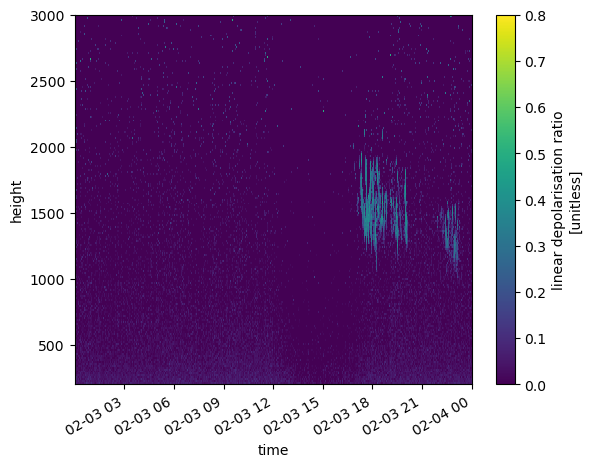

In [13]:
(ds.depol_linear.sel(height=slice(200,3000))).plot(x='time',y='height')

## Findings

So far, the only problem seems to be with loading in the calibration data. If we put the additional `*00.mpl.gz` in the glob string, this should work.